In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [9]:
sim_list = ['fR1.0-Sg10-Rc4.5', 'fR1.0-Sg40-Rc4.5',]
def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

In [14]:
# first get snapshots at intervals of 100 snaps (~ 500 Myr)
sn0_list = []
sn0_l4_list = []
sn1_list = []
sn1_l4_list = []
sn2_list = []
sn3_list = []
sn4_list = []

idx_list = np.array([0, 25, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800])

for idx in tqdm(idx_list):
    try:
        sn0 = read_snap(idx, 0, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn0_list.append(sn0)
    except:
        pass
    
    try:
        sn0 = read_snap(idx, 0, lvl='lvl4', parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn0_l4_list.append(sn0)
    except:
        pass

    try:
        sn1 = read_snap(idx, 1, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn1_list.append(sn1)
    except:
        pass
    
    try:
        sn1 = read_snap(idx, 1, lvl='lvl4', parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn1_l4_list.append(sn1)
    except:
        pass

#     try:
#         sn2 = read_snap(idx, 2, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
#         sn2_list.append(sn2)
#     except:
#         pass

#     try:
#         sn3 = read_snap(idx, 3, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
#         sn3_list.append(sn3)
#     except:
#         pass
    
#     try:
#         sn4 = read_snap(idx, 4, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
#         sn4_list.append(sn4)
#     except:
#         pass

A Jupyter Widget

In [11]:
def my_bin(X, Xbins, Y, func=np.mean):
    Xmin = Xbins[0]
    Xmax = Xbins[-1]
    assert Xmin==np.min(Xbins), "First entry of Xbins is not the min value"
    assert Xmax==np.max(Xbins), "Last entry of Xbins is not the max value"

    keys = np.logical_and(X > Xmin, X < Xmax)

    digit = np.digitize(X[keys], Xbins)
    X_avg = [X[keys][digit == i].mean() for i in range(1, len(Xbins))]
    Y_func = [func(Y[keys][digit == i]) for i in range(1, len(Xbins))]

    return np.array(X_avg), np.array(Y_func)

def compute_sfr_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    sfr = np.copy(sn.part0.sfr.value) # Msun/yr

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, sfr, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/yr/pc^2
        tot_sfr_binned[i] /= surf_area
        tot_sfr_binned[i] *= 1E9 # conerts to Msun/pc^2/Gyr

    return R_binned, tot_sfr_binned

def compute_gas_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value)

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance
    
    Rbool = np.abs(R-Rsun) < dR
    zbool = np.abs(z) < dz
    
    tot_mass = np.sum(gas_mass[np.logical_and(Rbool, zbool)])
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return tot_mass/tot_vol

def compute_star_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    
    star_mass = 0
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos = np.subtract(part.pos, center)
            R = np.linalg.norm(pos[:,:2], axis=1)
            z = pos[:,2]
            try:
                mass = 1E10 * np.copy(part.mass.value)
            except:
                mass = 1E10 * np.full(sn.NumPart_Total[i], sn.MassTable[i])
    
            Rbool = np.abs(R-Rsun) < dR
            zbool = np.abs(z) < dz
    
            star_mass += np.sum(mass[np.logical_and(Rbool, zbool)])
    
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return star_mass/tot_vol
    

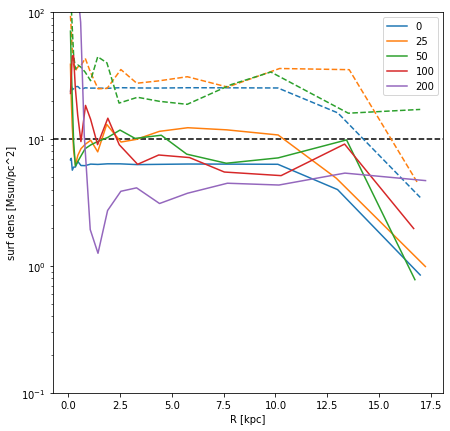

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.axhline(10, c='k', ls='dashed')



for i,idx in enumerate(idx_list):
    if idx not in [0, 25, 50, 100, 200]:#, 400, 600]:
        continue
    
    try:
        R0, gas0 = compute_HI_profile(sn0_list[i])
        l = ax.plot(R0, gas0, label=str(idx))
    except:
        l = None
        pass
        
    try:
        R1, gas1 = compute_HI_profile(sn1_list[i])
        if l is not None:
            ax.plot(R1, gas1, c=l[0].get_color(), ls='dashed')
        else:
            ax.plot(R1, gas1, ls='dashed')  
    except:
        pass
    
    try:
        R2, gas2 = compute_HI_profile(sn2_list[i])
#         ax.plot(R2, gas2, c=l[0].get_color(), ls='dotted')
    except:
        pass

ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]')
ax.legend()
plt.show()

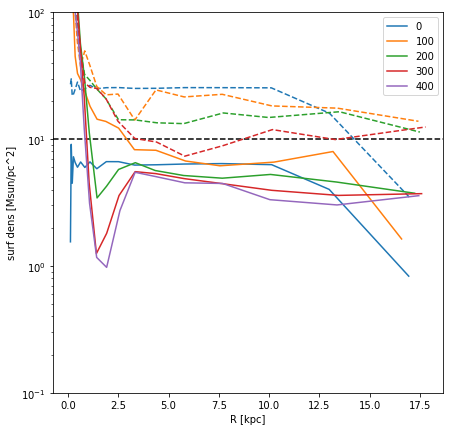

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.axhline(10, c='k', ls='dashed')



for i,idx in enumerate(idx_list):
    if idx not in [0, 100, 200, 300, 400]:#, 400, 600]:
        continue
    
    try:
        R0, gas0 = compute_HI_profile(sn0_l4_list[i])
        l = ax.plot(R0, gas0, label=str(idx))
    except:
        l = None
        pass
        
    try:
        R1, gas1 = compute_HI_profile(sn1_l4_list[i])
        if l is not None:
            ax.plot(R1, gas1, c=l[0].get_color(), ls='dashed')
        else:
            ax.plot(R1, gas1, ls='dashed')  
    except:
        pass
    
    try:
        R2, gas2 = compute_HI_profile(sn2_list[i])
#         ax.plot(R2, gas2, c=l[0].get_color(), ls='dotted')
    except:
        pass

ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]')
ax.legend()
plt.show()

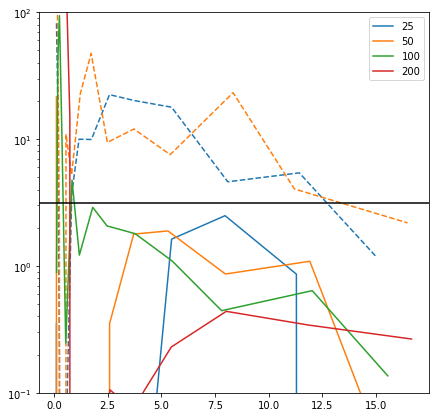

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
nbins=15

for i,idx in enumerate(idx_list):
    if idx not in [25, 50, 100, 200]:#, 200, 300]:#, 400, 600]:
        continue
    
    R0, sfr0 = compute_sfr_profile(sn0_list[i], nbins=nbins)
    l = ax.plot(R0, sfr0, label=str(idx))
    try:
        R1, sfr1 = compute_sfr_profile(sn1_list[i], nbins=nbins)
        ax.plot(R1, sfr1, c=l[0].get_color(), ls='dashed')
    except:
        pass
    
    try:
        pass
#         R2, sfr2 = compute_sfr_profile(sn2_list[i], nbins=nbins)
#         ax.plot(R2, sfr2, c=l[0].get_color(), ls='dotted')
    except:
        pass
    
    try:
        pass
#         R3, sfr3 = compute_sfr_profile(sn3_list[i], nbins=nbins)
#         ax.plot(R3, sfr3, c=l[0].get_color(), ls='dotted', label='name')
#         ax.plot(R3, sfr3, label='LumMass1E3')
    except:
        pass
    
    try:
        pass
#         R4, sfr4 = compute_sfr_profile(sn4_list[i], nbins=nbins)
#         ax.plot(R4, sfr4, c=l[0].get_color(), ls='dotted')
#         ax.plot(R4, sfr4, label='LumMass1E4')
    except:
        pass

ax.set(yscale='log', ylim=(0.1, 100))
ax.axhline(10.**(0.5), c='k')
ax.legend()
plt.show()

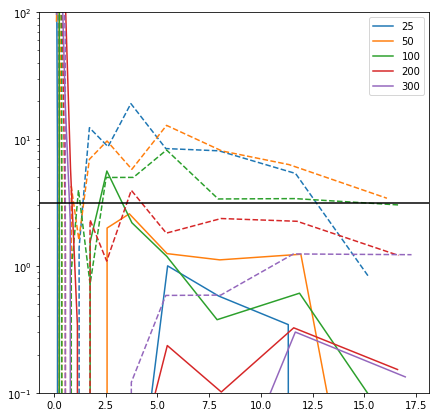

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
nbins=15

for i,idx in enumerate(idx_list):
    if idx not in [25, 50, 100, 200, 300]:#, 200, 300]:#, 400, 600]:
        continue
    
    R0, sfr0 = compute_sfr_profile(sn0_l4_list[i], nbins=nbins)
    l = ax.plot(R0, sfr0, label=str(idx))
    try:
        R1, sfr1 = compute_sfr_profile(sn1_l4_list[i], nbins=nbins)
        ax.plot(R1, sfr1, c=l[0].get_color(), ls='dashed')
    except:
        pass
    
    try:
        pass
#         R2, sfr2 = compute_sfr_profile(sn2_list[i], nbins=nbins)
#         ax.plot(R2, sfr2, c=l[0].get_color(), ls='dotted')
    except:
        pass
    
    try:
        pass
#         R3, sfr3 = compute_sfr_profile(sn3_list[i], nbins=nbins)
#         ax.plot(R3, sfr3, c=l[0].get_color(), ls='dotted', label='name')
#         ax.plot(R3, sfr3, label='LumMass1E3')
    except:
        pass
    
    try:
        pass
#         R4, sfr4 = compute_sfr_profile(sn4_list[i], nbins=nbins)
#         ax.plot(R4, sfr4, c=l[0].get_color(), ls='dotted')
#         ax.plot(R4, sfr4, label='LumMass1E4')
    except:
        pass

ax.set(yscale='log', ylim=(0.1, 100))
ax.axhline(10.**(0.5), c='k')
ax.legend()
plt.show()